In [2]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from pathlib import Path

plt.rcParams['figure.figsize'] = (6, 4)
data_path = Path('ckpt/block_normal/Ours_GAT/400_gat_full_attn.fp16.npz')  

In [11]:
data = np.load(data_path)['arr_0']
print('Loaded', data.shape)
#shape (E, T, H, N, N)

Loaded (10, 24, 4, 16, 16)


In [ ]:
#Normalized entropy 
def entropy(mat, axis=-1):
    p = mat.astype(np.float32)
    mask = p > 0
    logp = np.zeros_like(p)
    logp[mask] = np.log(p[mask])
    return -(p *logp).sum(axis=axis) / (p.shape[-1]*np.log(p.shape[-1]))

In [25]:
ep_mean = data.mean(axis=1)   # (E,H,N,N)
E, H, N, _ = ep_mean.shape

[[17.014347 17.088057 17.03746  16.993195]
 [16.975971 17.099289 17.014355 17.062145]
 [17.070383 17.056099 17.083069 17.079826]
 [17.053944 16.999203 16.98773  17.033474]
 [17.08235  17.034294 17.08573  17.032267]
 [17.00741  17.041344 17.067966 17.02053 ]
 [17.055637 17.06239  17.065521 17.042553]
 [17.064264 17.112478 16.956625 17.01152 ]
 [17.063519 17.048958 17.041267 17.076542]
 [17.060879 17.042547 16.981316 17.082458]]


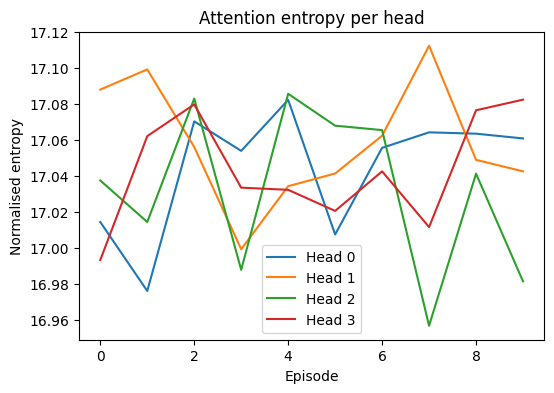

In [29]:
ent = entropy(ep_mean, axis=(-2, -1))
print(ent)
for h in range(H):
    plt.plot(ent[:, h], label=f'Head {h}')
plt.xlabel('Episode'); plt.ylabel('Normalised entropy')
plt.title('Attention entropy per head')
plt.legend(); plt.show()
